# <center>Metody Numeryczne</center>

# Laboratorium 9: Interpolacja


**Wykonał:** \<imię i nazwisko\>

<br>

### **Metoda zaliczenia:**

Podczas zajęć należy wykonać poniższe polecenia oraz udzielić odpowiedzi na pytania zamieszczone w treści zadań. 

Wszystkie funkcje wymagane w ramach ćwiczenia należy zaimplementować w pliku `main.py`. Poprawność ich działania należy zweryfikować za pomocą testów jednostkowych dostępnych w pliku `test_main.py`.

### **Cel zajęć:**

Celem laboratorium jest praktyczne zapoznanie z zagadnieniem interpolacji wielomianowej, ze szczególnym uwzględnieniem jej wariantów numerycznie stabilnych. W ramach zajęć przeanalizowane zostanie działanie interpolacji barycentrycznej opartej na węzłach Czebyszewa.


### **Uwagi wstępne:**
- Funkcje wymagające implementacji (lub zaimplementowane na poprzednich laboratoriach) oznaczone są pochyłą czcionką maszynową (np. *`my_func()`*).

- W skrypcie stosuje się następujące skróty:

    - `np` - `numpy`,
    - `sp` - `scipy`.

---

In [13]:
# !python -m pip install numpy scipy matplotlib

import main

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import copy

---

### **Zadanie 1.**

W celu wykonywania interpolacji należy przygotować funkcję wyliczającą wektor [węzłów Czebyszewa](https://en.wikipedia.org/wiki/Chebyshev_nodes) drugiego rodzaju (funkcja *`chebyshev_nodes()`*) dany wzorem:
  
$$
x_k = \cos\left(\cfrac{k\pi}{n}\right),\ \ \ k = 0,1,2,...,n
$$

oraz wagi barycentryczne dla tego typu wezłów (funkcja *`bar_cheb_weights()`*):

$$
\begin{align*}
    w_j={}&(-1)^j\delta_j\\
    \delta_j={}&
    \begin{cases}
        \frac{1}{2}, \quad j=\{0, n\}\\
        1, \quad j\in(0,n)
    \end{cases}
\end{align*}
$$


---

### **Zadanie 2.**

Zaimplementuj podane funkcje, które będą używane w dalszej części laboratorium:

1. Ciągłą nieróżniczkowalną: $f_1(x) = \mathrm{sgn}(x)x+x^2$.

2. Różniczkowalną jednokrotnie: $f_2(x) = \mathrm{sgn}(x)x^{2}$.

3. Różniczkowalną trzykrotnie: $f_3(x)=|\sin(5 x)|^3$.

4. Trzy analityczne postaci: $f_{4a}(x) = \cfrac{1}{1+ax^2} \ $ dla $a \in \{1,25,100\}$. 

5. Nieciągłą: $f_5(x) = \mathrm{sgn}(x)$.

Funkcje można zaimplementować w notebooku lub w pliku `main.py`. 

>**Wskazówka:** Do definicji funkcji w notatniku można użyć [wyrażenia lambda](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions).
>
>$\mathrm{sgn}(x)$ to funkcja [signum](https://en.wikipedia.org/wiki/Sign_function).

In [29]:
# ===== Twoja implementacja tutaj =====
def chebyshev_nodes(n: int = 10) -> np.ndarray | None:
    if not isinstance(n, int) or n<=0:
        return None
    k = np.arange(n)
    if n == 1:
        return np.array([0.0])
    x = np.cos(k*np.pi/(n-1))
    return x
print (chebyshev_nodes(3))


def bar_cheb_weights(n: int = 10) -> np.ndarray | None:

    j = np.arange(n)
    sigj = np.ones(n)
    sigj[0] = 1/2
    sigj[-1] = 1/2
    return ((-1)**j)*sigj
print(bar_cheb_weights(3))

def f1(x):
    return np.sign(x)*x - x**2
def f2(x):
    return np.sign(x)*x**2
def f3(x):
    return (np.abs(np.sin(5*x)))**3
def f4(x, a):
    return 1/(1+a*x**2)
def f5(x):
    return np.sign(x)


[ 1.000000e+00  6.123234e-17 -1.000000e+00]
[ 0.5 -1.   0.5]


---

### **Zadanie 3.**

Do oceny jakości interpolacji stosuje się normę wektorową $\ell_{\infty}$. Dla różnicy wektorów definiujemy ją jako:  
  
$$
\ell_{\infty} = ||\mathbf{x_1}-\mathbf{x_2}||_\infty = \sup\{|\mathbf{x_1}-\mathbf{x_2}|\}
$$  
  
Zaimplementuj funkcję *`L_inf()`* wyznaczającą normę $\ell_{\infty}$. 


In [30]:
def L_inf(
    xr: int | float | list | np.ndarray, x: int | float | list | np.ndarray
) -> float | None:

    xr_arr = np.asarray(xr)
    x_arr = np.asarray(x)

    if xr_arr.shape != x_arr.shape:
        return None

    return float(np.max(np.abs(xr_arr - x_arr)))

---

### **Zadanie 4.**

**Punkt 1.**

Zaimlementuj wzór barycentryczny podany na wykładzie jako funkcję *`barycentric_inte()`*.

<br>

**Punkt 2.**

Dla funkcji ciągłej nieróżniczkowalnej z **Zadania 2.** ($f_1(x)$) przeprowadź interpolację metodą [barycentryczną](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf) zarówno przy użyciu funkcji [`sp.interpolate.barycentric_interpolate()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.barycentric_interpolate.html) jak i korzystając z zaimplementowanego wzoru barycentrycznego. 

W tym celu dla $n \in \{1, 2, 3, 4, 5\}$:

1. W węzłach Czebyszewa wykonaj interpolację rzędu $10^n$.

2. Wykreśl wykresy obrazujące wyniki interpolacji (wykres oryginalnej funkcji i funkcji interpolującej w $1000$ punktach).

3. Zbadaj jakość interpolacji za pomocą normy $\ell_{\infty}$.

Opisz jak zmieniały się wartość normy $\ell_{\infty}$ oraz czas obliczeń w zależności od rzędu interpolacji.


In [31]:
def barycentric_inte(
    xi: np.ndarray, yi: np.ndarray, wi: np.ndarray, x: np.ndarray
) -> np.ndarray | None:
    if not all(isinstance(arg, np.ndarray) for arg in [xi, yi, wi, x]):
        return None
    if xi.shape != yi.shape or xi.shape != wi.shape:
        return None
    
    diff = x[:, None] - xi
    eps = 1e-15
    mask = np.abs(diff) < eps
    diff[mask] = 1.0
    kernels = wi / diff
    
    numerator = np.sum(kernels * yi, axis=1)
    denominator = np.sum(kernels, axis=1)
    result = numerator / denominator

    x_indices, node_indices = np.where(mask)
    result[x_indices] = yi[node_indices]

    return result

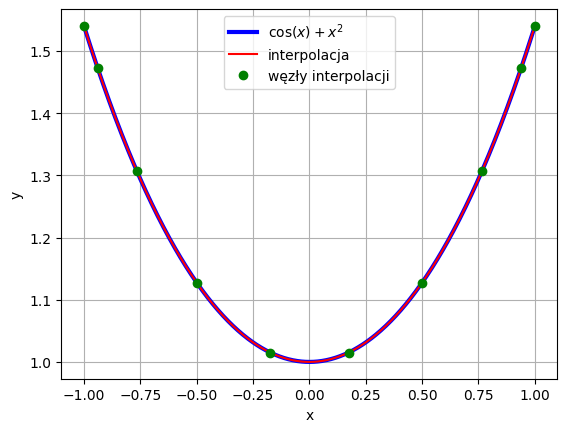

In [32]:
# Przykład użycia interpolacji barycentrycznej z wykorzystaniem węzłów Czebyszewa

# Funkcja do interpolacji
def f(x):
    return np.cos(x) + x**2

# Wektor współrzędnych, dla których chcemy wyliczyć wartości wielomianu interpolacyjnego
x = np.linspace(-1, 1, 1000)

# Węzły Czebyszewa
n = int(1e1)  # Liczba węzłów
xch = chebyshev_nodes(n)

# Interpoalcja
yimp = sp.interpolate.barycentric_interpolate(xch, f(xch), x)

plt.plot(x, f(x), 'b', linewidth=3, label=r'$\cos(x)+x^2$')
plt.plot(x, yimp, 'r', label='interpolacja')
plt.plot(xch, f(xch), 'go', label='węzły interpolacji')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc=0)
plt.grid()
plt.show()

---

### **Zadanie 5.**

Dla funkcji jednokrotnie ($f_2(x)$) i trzykrotnie ($f_3(x)$) różniczkowalnych z **Zadania 2.** należy przeanalizować w pętli jakość interpolacji dla interpolacji rzędu $10^n$, gdzie $n \in \{1, 2, 3, 4, 5\}$. 

W tym celu:

1. Wylicz wartość funkcji i wielomianu interpolacyjnego w $1000$ punktów (nie będącymi węzłami interpolacji np. punkty równoodległe).

2. Wylicz normę różnicy tych wektorów (normę błędu) dla każdego badanego rzędu. Maksymalny rząd należy przyjąć gdy błąd będzie na poziomie zera maszynowego.

3. Dla każdej z funkcji sporządź wykres w skali podwójnie logarytmicznej (obie osie), w którym oś argumentów to rząd interpolacji a oś wartości to odpowiadająca mu norma błędu.

4. Dla porównania umieść na wykresie dodatkowo wykres $n^{-v}$, gdzie $v$ to rząd najwyższej pochodnej funkcji (zobacz wykład).

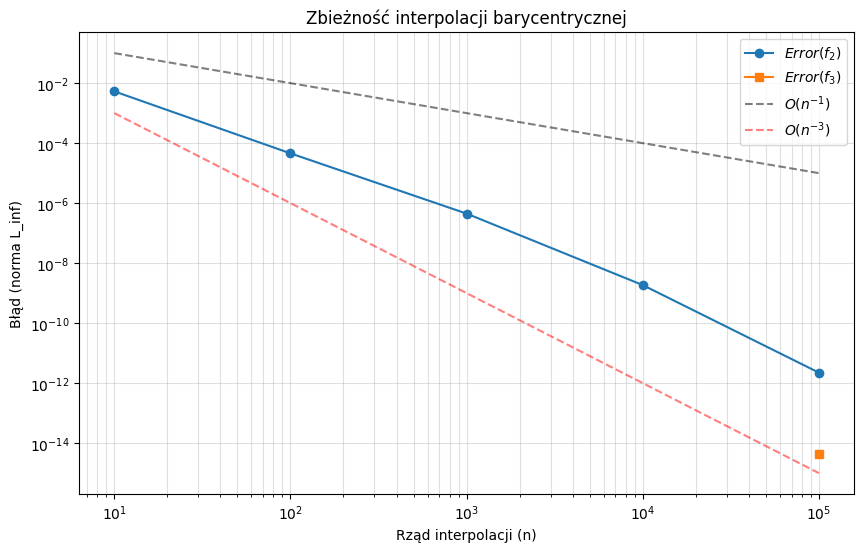

In [33]:
rzedy = [10**n for n in range(1, 6)] # 10, 100, 1000, 10000, 100000
x_plot = np.linspace(-1, 1, 1000)    # Punkty do badania błędu

# Słowniki na wyniki
bledy_f2 = []
bledy_f3 = []

# --- Analiza f2 (jednokrotnie różniczkowalna) ---
for n in rzedy:
    nodes = chebyshev_nodes(n)
    weights = bar_cheb_weights(n)
    y_nodes = f2(nodes)
    
    y_interp = barycentric_inte(nodes, y_nodes, weights, x_plot)
    
    error = L_inf(f2(x_plot), y_interp)
    bledy_f2.append(error)
    
    if error < 1e-15: # Zero maszynowe
        print(f"f2: Osiągnięto precyzję maszynową dla n={n}")
        break

# --- Analiza f3 (trzykrotnie różniczkowalna) ---
for n in rzedy:
    nodes = chebyshev_nodes(n)
    y_nodes = f3(nodes)
    
    y_interp = barycentric_inte(nodes, y_nodes, weights, x_plot)
    
    error = L_inf(f3(x_plot), y_interp)
    bledy_f3.append(error)

# --- Wykresy ---
plt.figure(figsize=(10, 6))

# Wykres błędów
plt.loglog(rzedy[:len(bledy_f2)], bledy_f2, 'o-', label=r'$Error(f_2)$')
plt.loglog(rzedy[:len(bledy_f3)], bledy_f3, 's-', label=r'$Error(f_3)$')

# Linie teoretyczne n^-v
# Dla f2 (v=1) -> n^-1
n_range = np.array(rzedy)
plt.loglog(n_range, 1/n_range, 'k--', alpha=0.5, label=r'$O(n^{-1})$')

# Dla f3 (v=3) -> n^-3
plt.loglog(n_range, 1/(n_range**3.0), 'r--', alpha=0.5, label=r'$O(n^{-3})$')

plt.xlabel('Rząd interpolacji (n)')
plt.ylabel('Błąd (norma L_inf)')
plt.title('Zbieżność interpolacji barycentrycznej')
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.legend()
plt.show()

---

### **Zadanie 6.**

Dla funkcji nieciągłej z **Zadania 2.** ($f_5(x)$) przeanalizować należy [efekt Gibbsa](https://en.wikipedia.org/wiki/Gibbs_phenomenon).

1. Oddzielnie dla parzystych i nieparzystych $n$ wylicz jaki jest minimalny błąd niezależny od rzędu. 

2. Odpowiedz dlaczego wartości dla parzystych i nieparzystych $n$ się różnią.

> **Wskazówka:** Wykonaj wykres funkcji i jej funkcji interpolującej.

Średni błąd dla nieparzystej liczby węzłów (n odd): 1.9825
Średni błąd dla parzystej liczby węzłów (n even):   0.9703


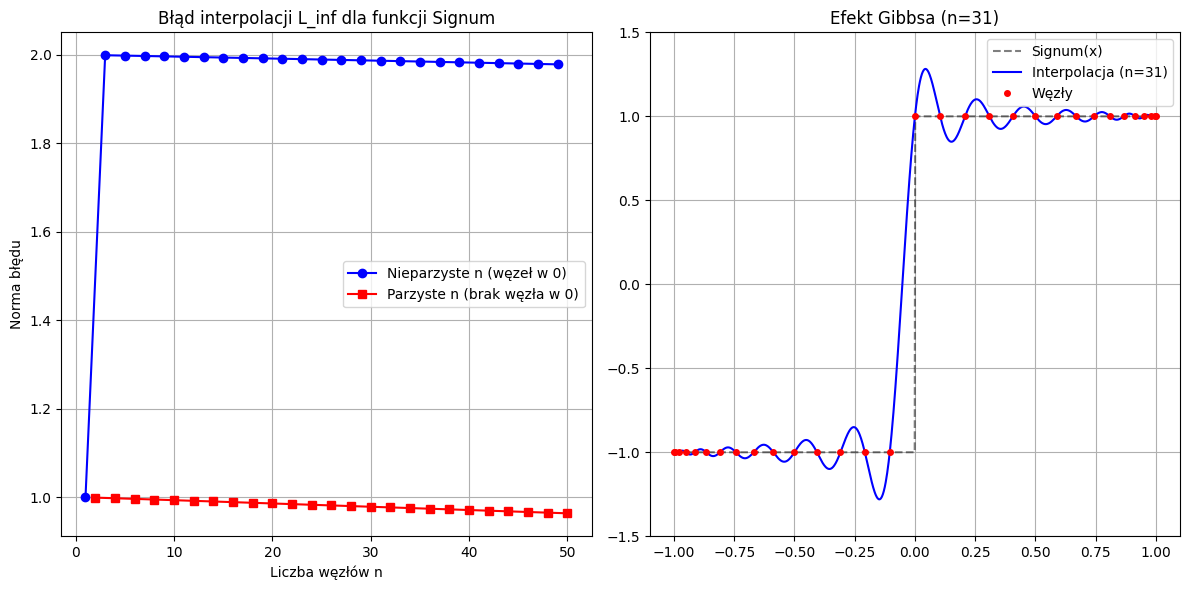

In [ ]:
n_values = range(1, 51)  # Sprawdzamy n od 1 do 50
errors_odd = []
errors_even = []
ns_odd = []
ns_even = []

x_dense = np.linspace(-1, 1, 1000)  # Gęsta siatka punktów do oceny błędu
y_exact = f5(x_dense)

for n in n_values:
    # Generowanie węzłów
    nodes = chebyshev_nodes(n)
    
    # Generowanie wag (funkcja zwraca teraz jedną tablicę - to jest poprawne)
    weights = bar_cheb_weights(n)
    
    # Obliczenie wartości w węzłach
    y_nodes = f5(nodes)
    
    # Interpolacja
    y_interp = barycentric_inte(nodes, y_nodes, weights, x_dense)
    
    # Obliczenie błędu L_inf
    error = L_inf(y_exact, y_interp)
    
    # Rozdzielenie na parzyste i nieparzyste n
    if n % 2 == 0:
        errors_even.append(error)
        ns_even.append(n)
    else:
        errors_odd.append(error)
        ns_odd.append(n)

# Wyświetlenie średnich błędów dla dużych n (asymptotycznie)
print(f"Średni błąd dla nieparzystej liczby węzłów (n odd): {np.mean(errors_odd[-10:]):.4f}")
print(f"Średni błąd dla parzystej liczby węzłów (n even):   {np.mean(errors_even[-10:]):.4f}")

# 2. Wykresy
plt.figure(figsize=(12, 6))

# Wykres 1: Zależność błędu od n
plt.subplot(1, 2, 1)
plt.plot(ns_odd, errors_odd, 'bo-', label='Nieparzyste n (węzeł w 0)')
plt.plot(ns_even, errors_even, 'rs-', label='Parzyste n (brak węzła w 0)')
plt.title('Błąd interpolacji L_inf dla funkcji Signum')
plt.xlabel('Liczba węzłów n')
plt.ylabel('Norma błędu')
plt.legend()
plt.grid()

# Wykres 2: Kształt funkcji interpolującej (Efekt Gibbsa)
plt.subplot(1, 2, 2)
n_plot = 31  # Wybieramy n nieparzyste, aby pokazać zachowanie z węzłem w 0
nodes = chebyshev_nodes(n_plot)
w = bar_cheb_weights(n_plot)
y_interp = barycentric_inte(nodes, f5(nodes), w, x_dense)

plt.plot(x_dense, y_exact, 'k--', label='Signum(x)', alpha=0.5)
plt.plot(x_dense, y_interp, 'b-', label=f'Interpolacja (n={n_plot})')
plt.plot(nodes, f5(nodes), 'ro', markersize=4, label='Węzły')
plt.title(f'Efekt Gibbsa (n={n_plot})')
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


---

**Materiały uzupełniające:**
- [Scipy Lecture Notes](http://www.scipy-lectures.org/index.html)
- [NumPy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html#numpy-for-matlab-users)
- [Python Tutorial - W3Schools](https://www.w3schools.com/python/default.asp)
- [NumPy](https://www.numpy.org)
- [Matplotlib](https://matplotlib.org/)
- [Anaconda](https://www.anaconda.com/)
- [Learn Python for Data Science](https://www.datacamp.com/learn-python-with-anaconda?utm_source=Anaconda_download&utm_campaign=datacamp_training&utm_medium=banner)
- [Learn Python](https://www.learnpython.org/)
- [Wujek Google](https://google.pl) i [Ciocia Wikipedia](https://pl.wikipedia.org/wiki/Wikipedia:Strona_g%C5%82%C3%B3wna)